In [32]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
!pip install livelossplot
from livelossplot import PlotLosses


#  ────────────────────────────────────────────────────────────────────
#   DATA IMPORT                                                        
#  ────────────────────────────────────────────────────────────────────
data = pd.read_parquet('/kaggle/input/resume-features-cleaned/resume-features.parquet', columns=['Category', 'cleaned_resumes'])

In [35]:
#  ────────────────────────────────────────────────────────────────────
#   CPU VS GPU                                                         
#  ────────────────────────────────────────────────────────────────────
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Using cuda.


In [36]:
#  ────────────────────────────────────────────────────────────────────
#   DATASET                                                            
#  ────────────────────────────────────────────────────────────────────
def tokenization(texts, tokenizer_type='basic_english', specials=['<unk>'], device=device):
    tokenizer = get_tokenizer(tokenizer_type)
    tokens = [tokenizer(text) for text in texts]
    vocab = build_vocab_from_iterator(tokens, specials=specials)
    vocab.set_default_index(vocab['<unk>'])

    tokenized_texts = [torch.tensor([vocab[token] for token in text], dtype=torch.int64, device=device) for text in tokens]

    return tokenized_texts, vocab

class ResumeDataset(Dataset):
    def __init__(self, data, device=device):
        super().__init__()
        self.text = data.iloc[:,1]
        self.labels = torch.tensor(data.iloc[:,0].values, device=device)
        
        self.tokenized_texts, self.vocab = tokenization(self.text, device=device)

    def __len__(self):
        return len(self.labels)

    def vocab_size(self):
        return len(self.vocab)

    def num_class(self):
        return len(self.labels.unique())

    def __getitem__(self, idx):
        sequence = self.tokenized_texts[idx]
        label = self.labels[idx]
        return sequence, label

def collate_fn(batch, device=device):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    return sequences_padded, labels

dataset = ResumeDataset(data)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [37]:
#  ────────────────────────────────────────────────────────────────────
#   MODEL DEFINITION                                                   
#  ────────────────────────────────────────────────────────────────────
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        # Dimensions of embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        # Embedding dimension
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Initialize positional embedding matrix (vocab_size, d_model)
        pe = torch.zeros(vocab_size, d_model)
        # Positional vector (vocab_size, 1)
        position = torch.arange(0, vocab_size).unsqueeze(1)
        # Frequency term
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000) / d_model))
        # Sinusoidal functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # Add batch dimension
        pe = pe.unsqueeze(0)
        # Save to class
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class LayerNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        # Learnable parameters
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.ones(d_model))
        # Numerical stability in case of 0 denominator
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # Linear combination of layer norm with parameters gamma and beta
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class ResidualConnection(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        return self.dropout(self.norm(x1 + x2))

class FeedForward(nn.Module):
    def __init__(self, d_model: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float =0.1, qkv_bias: bool = False, is_causal: bool = False):
        super().__init__()
        assert d_model % num_heads == 0,  "d_model is not divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.dropout = dropout
        self.is_causal = is_causal

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=qkv_bias)
        self.linear = nn.Linear(num_heads * self.head_dim, d_model)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_length = x.shape[:2]

        # Linear transformation and split into query, key, and value
        qkv = self.qkv(x)  # (batch_size, seq_length, 3 * embed_dim)
        qkv = qkv.view(batch_size, seq_length, 3, self.num_heads, self.head_dim)  # (batch_size, seq_length, 3, num_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, seq_length, head_dim)
        queries, keys, values = qkv  # 3 * (batch_size, num_heads, seq_length, head_dim)

        # Scaled Dot-Product Attention
        context_vec = F.scaled_dot_product_attention(queries, keys, values, attn_mask=mask, dropout_p=self.dropout, is_causal=self.is_causal)

        # Combine heads, where self.d_model = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        context_vec = self.dropout_layer(self.linear(context_vec))

        return context_vec

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.multihead_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.residual1 = ResidualConnection(d_model, dropout)
        self.feed_forward = FeedForward(d_model, hidden_dim, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)

    def forward(self, x, mask=None):
        x = self.residual1(x, self.multihead_attention(x, mask))
        x = self.residual2(x, self.feed_forward(x))
        return x

class EncoderStack(nn.Module):
    def __init__(self, d_model: int, num_heads: int, hidden_dim: int, num_layers: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, hidden_dim, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_heads: int, hidden_dim: int, num_layers: int, out_features: int, dropout: float = 0.1):
        super().__init__()
        self.embedding = EmbeddingLayer(vocab_size, d_model)
        self.positional_embedding = PositionalEmbedding(vocab_size, d_model, dropout)
        self.encoder = EncoderStack(d_model, num_heads, hidden_dim, num_layers, dropout)
        self.classifier = nn.Linear(d_model, out_features)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.positional_embedding(x)
        x = self.encoder(x, mask)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x


In [38]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler=None, visualize=None, device=device, save=None):
    """
    This function trains a PyTorch model using the given data loaders and hyperparameters.
    The function also supports visualization using liveloss or matplotlib.

    Parameters:
    - model: object: A PyTorch model object.
    - train_loader: DataLoader: A DataLoader object containing the training data.
    - val_loader: DataLoader: A DataLoader object containing the validation data.
    - criterion: object: A loss function object.
    - optimizer: object: An optimizer object.
    - epochs: int: The number of epochs to train the model.
    - scheduler: object: A learning rate scheduler object.
    - visualize: str: A string that determines the visualization method. Choose from [None, 'liveloss', 'matplotlib'].
    - save_path: str: A string containing the path to save the best model.

    Returns:
    Model performance metrics and visualization.
    """
    best_val_loss = float('inf')
    best_val_accuracy = float('inf')
    best_model_wts = None
    
    assert visualize in [None, 'liveloss', 'matplotlib'], "Invalid visualization method. Choose from [None, 'liveloss', 'matplotlib']."

    if visualize == 'liveloss':
        liveloss = PlotLosses()

    if visualize == 'matplotlib':
        train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training Phase
        logs = {}
        model.train()
        train_loss, train_corrects, train_total = 0.0, 0, 0

        for data, labels in tqdm(train_loader, desc="Training", leave=False):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)
            train_total += data.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_corrects.double() / train_total

        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for data, labels in tqdm(val_loader, desc="Validation", leave=False):
                data, labels = data.to(device), labels.to(device)

                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * data.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += data.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_corrects.double() / val_total

        if visualize != 'liveloss':
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
            print(f"  Val Loss: {val_loss:.4f} |   Val Acc: {val_accuracy:.4f}")

        if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Save logs for visualization
        if visualize == 'liveloss':
            logs['log loss'] = train_loss
            logs['accuracy'] = train_accuracy.item()
            logs['val_log loss'] = val_loss
            logs['val_accuracy'] = val_accuracy.item()
            liveloss.update(logs)
            liveloss.send()
        elif visualize == 'matplotlib':
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy.cpu())  # Move to CPU
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy.cpu())  # Move to CPU

        # Check if current model is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()
            print(f"👉 New best model with val loss: {val_loss:.4f}!")

        print("-" * 30)

    # Save best model
    if save and best_model_wts:
        torch.save(best_model_wts, save)
        print(f"Best model saved:")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Plot in matplotlib
    if visualize == 'matplotlib':
        plt.figure(figsize=(10, 5))

        # Plot training and validation losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        # Plot training and validation accuracies
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    print("✅ Training complete!")

def test_model(model, test_loader, criterion, device=device):
    """
    This function tests a PyTorch model using the given data loader and loss function.

    Parameters:
    - model: object: A PyTorch model object.
    - test_loader: DataLoader: A DataLoader object containing the testing data.
    - criterion: object: A loss function object.

    Returns:
    Model performance metrics.
    """
    model.eval()
    test_loss, test_corrects, test_total = 0.0, 0, 0

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Testing", leave=False):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            test_total += data.size(0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = test_corrects.double() / test_total

    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")
    print("✅ Testing complete!")

    return test_loss, test_accuracy


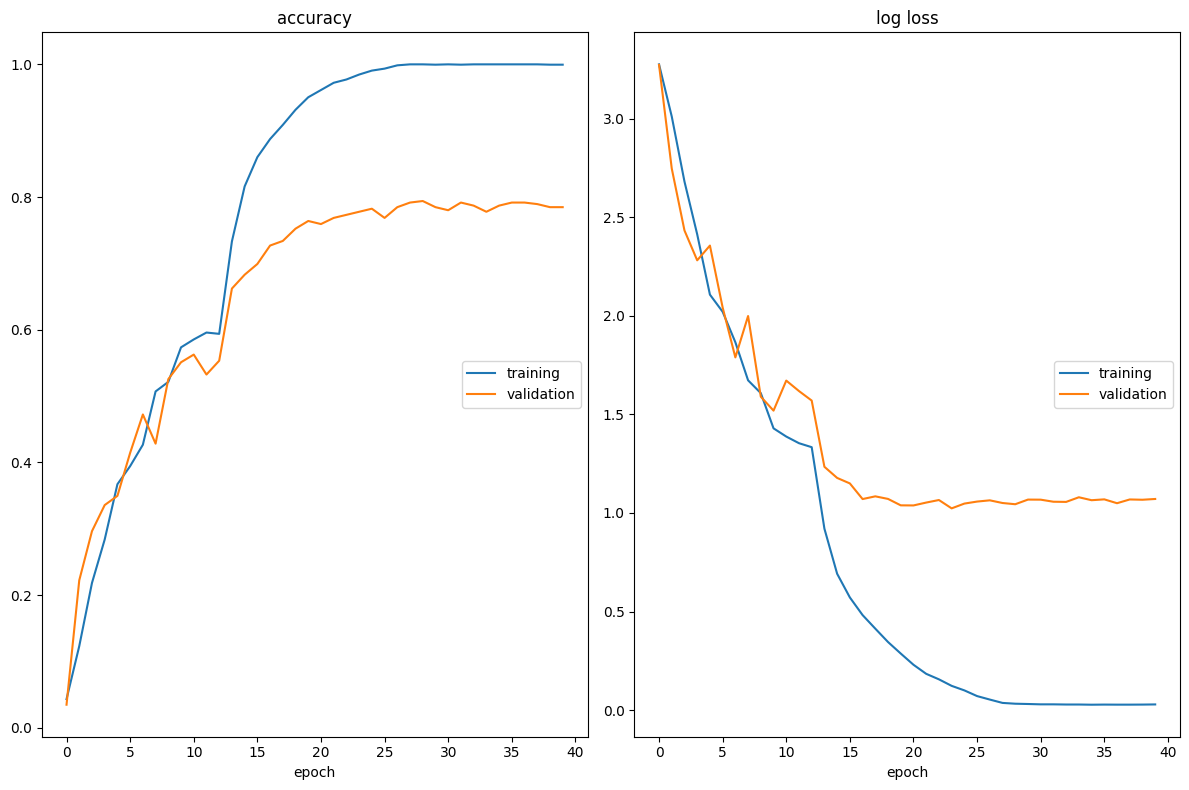

accuracy
	training         	 (min:    0.043, max:    1.000, cur:    1.000)
	validation       	 (min:    0.035, max:    0.794, cur:    0.785)
log loss
	training         	 (min:    0.027, max:    3.276, cur:    0.029)
	validation       	 (min:    1.023, max:    3.273, cur:    1.071)
------------------------------
Best model saved:
Val Loss: 1.0709 | Val Acc: 0.7847
✅ Training complete!


In [43]:
vocab_size = dataset.vocab_size()
d_model = 80
num_heads = 4
hidden_dim = 180
num_layers = 4
out_features = dataset.num_class()

model = TransformerEncoderModel(vocab_size, d_model, num_heads, 
                                hidden_dim, num_layers, out_features, dropout=0).to(device)
criterion = CrossEntropyLoss()
loss = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(loss, patience=2)
epochs = 40

train_model(model, train_loader, val_loader, epochs, criterion, loss, scheduler, 
            visualize='liveloss', 
            save='enc-model.pth.gz'
           )

In [44]:
accuracy = test_model(model, test_loader, criterion)

Test Loss: 1.2526 | Test Acc: 0.7454
✅ Testing complete!
